In [1]:
!pip install -U scikit-learn
!pip install lightgbm
!pip install -U ml-research

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity,
    outcome_sensitivity,
    bootstrapped_explanation_consistency,
    cross_method_explanation_consistency,
    cross_method_outcome_consistency,
    explanation_sensitivity_all_neighbors,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlresearch.utils import check_random_states, set_matplotlib_style
from xai_ranking.utils import scores_to_ordering

RNG_SEED = 42

In [2]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [3]:
datasets = [
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
    },
]

xai_methods = [
    {"iterations": 1, "name": "SHAP", "experiment": shap_experiment, "kwargs": {}},
    # {
    #     "iterations": 1,
    #     "name": "ShaRP",
    #     "experiment": sharp_experiment,
    #     "kwargs": {
    #         "verbose": True,
    #         # "sample_size": 150,
    #         "measure": "shapley",
    #         "n_jobs": -1,
    #         "replace": True
    #     }
    # },
    {
        "iterations": 1,
        "name": "ShaRP",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True,
            "qoi": "rank_score",
        },
    },
    # {
    #     "iterations": 1,
    #     "name": "ShaRP",
    #     "experiment": sharp_experiment,
    #     "kwargs": {
    #         "verbose": True,
    #         # "sample_size": 150,
    #         "measure": "shapley",
    #         "n_jobs": -1,
    #         "replace": True,
    #         "qoi": "top_k"
    #     }
    # },
]

total_states = sum(map(lambda x: x["iterations"], xai_methods)) * len(datasets)
random_states = (x for x in check_random_states(RNG_SEED, total_states))

In [4]:
results = {}
for dataset in datasets:
    results[dataset["name"]] = {}
    for xai_method in xai_methods:
        results[dataset["name"]][xai_method["name"]] = []

        experiment_func = xai_method["experiment"]
        score_func = dataset["scorer"]

        X, ranks, scores = dataset["data"]

        for iteration_idx in range(xai_method["iterations"]):
            random_state = next(random_states)
            if "done" in dataset and dataset["done"]:
                continue

            kwargs = {} if "kwargs" not in xai_method else xai_method["kwargs"]
            if dataset["name"] == "Moving Company" and xai_method["name"].endswith(
                "ShaRP"
            ):
                kwargs["sample_size"] = 150

            contributions = experiment_func(
                X, score_func, random_state=random_state, **kwargs
            )

            results[dataset["name"]][xai_method["name"]].append(contributions)
            result_df = pd.DataFrame(contributions, columns=X.columns, index=X.index)
            result_df.to_csv(
                f"results/_contributions_{dataset['name']}_{xai_method['name']}_{iteration_idx}.csv"
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [6]:
results = read_results_from_files()

In [7]:
results

{'Synthetic_0': {'SHAP': [            n1        n2        n3
   0    -0.004996 -0.077648  0.002471
   1    -0.121823 -0.004476 -0.022182
   2    -0.086295  0.026021  0.009002
   3    -0.041216  0.018673 -0.024679
   4    -0.097949  0.026314 -0.012485
   ...        ...       ...       ...
   1995  0.138790  0.003391  0.022669
   1996 -0.105923  0.049628 -0.017760
   1997 -0.003507 -0.054039  0.052952
   1998  0.038682 -0.002391 -0.035399
   1999  0.038353  0.086160  0.029063
   
   [2000 rows x 3 columns]],
  'ShaRP': [            n1        n2        n3
   0    -0.005501 -0.070699  0.009081
   1    -0.121734  0.003604 -0.015458
   2    -0.086206  0.034179  0.015070
   3    -0.041422  0.026031 -0.018839
   4    -0.097859  0.034515 -0.007132
   ...        ...       ...       ...
   1995  0.138880  0.011549  0.028737
   1996 -0.106071  0.056716 -0.011742
   1997 -0.003806 -0.046201  0.058910
   1998  0.038178  0.004558 -0.028790
   1999  0.038443  0.094318  0.035131
   
   [2000 rows x 3 c

# Explanation Sensitivity

In [8]:
help(explanation_sensitivity)

Help on function explanation_sensitivity in module xai_ranking.metrics._sensitivity:

explanation_sensitivity(original_data, contributions, rankings, n_neighbors=10, agg_type='mean', measure='kendall', similar_outcome=True, **kwargs)



In [9]:
methods = [
    method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")
]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = explanation_sensitivity(
                dataset["data"][0],
                results[dataset["name"]][method][0],
                rankings,
                measure="kendall",
            )
            expl_sens_res[method][dataset["name"]] = result[0]
            expl_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [10]:
pd.DataFrame(expl_sens_res)

,SHAP,ShaRP
Synthetic_0,-0.337233,-0.342600
Synthetic_1,-0.238833,-0.238533
Synthetic_2,-0.276200,-0.273900


## Reverse explanation sensitivity

In [11]:
methods = [
    method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")
]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = explanation_sensitivity(
                dataset["data"][0],
                results[dataset["name"]][method][0],
                rankings,
                measure="kendall",
                # n_features=0.8,
                similar_outcome=False,
            )
            expl_sens_res[method][dataset["name"]] = result[0]
            expl_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [12]:
pd.DataFrame(expl_sens_res)

,SHAP,ShaRP
Synthetic_0,-0.590633,-0.597000
Synthetic_1,-0.614500,-0.610700
Synthetic_2,-0.617433,-0.608767


## Explanation Sensitivity Plot

In [13]:
import seaborn as sns

2000


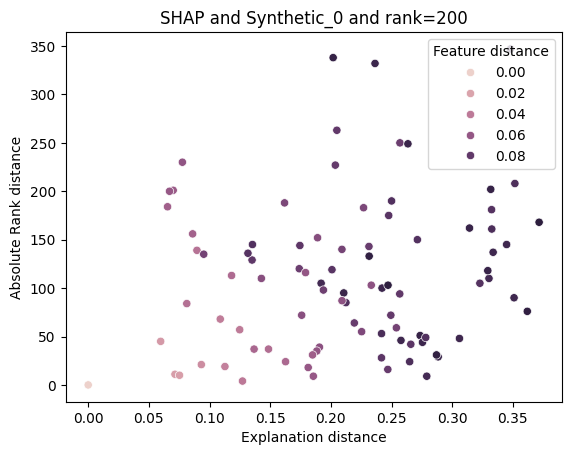

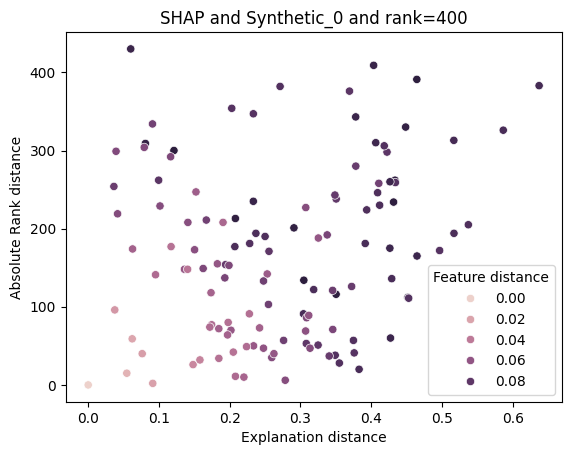

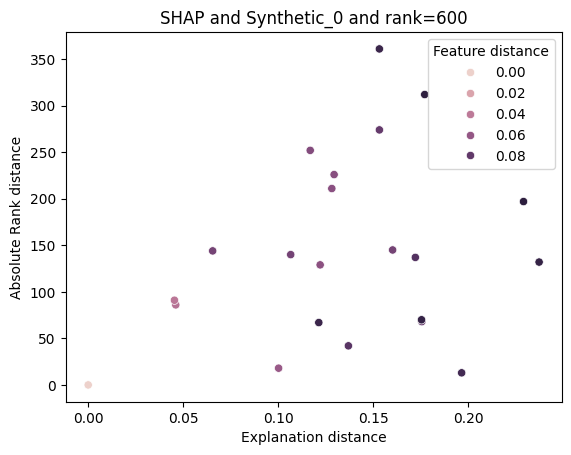

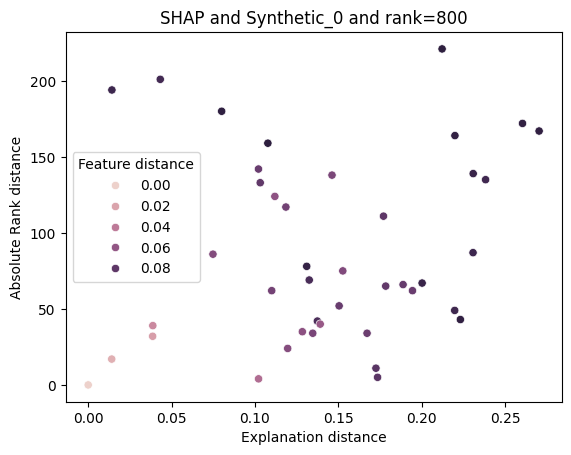

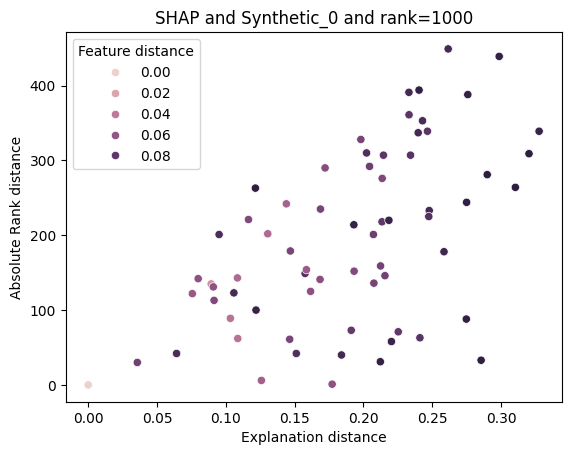

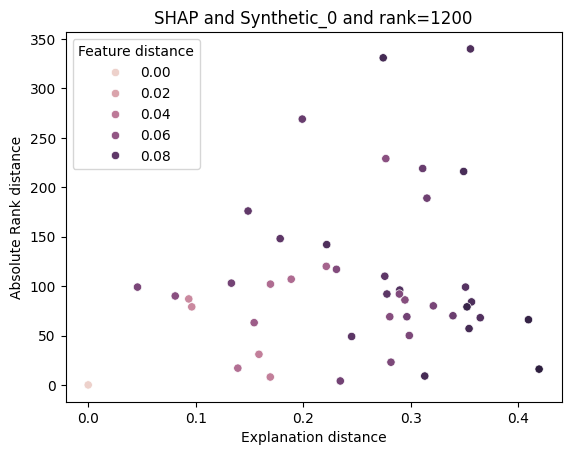

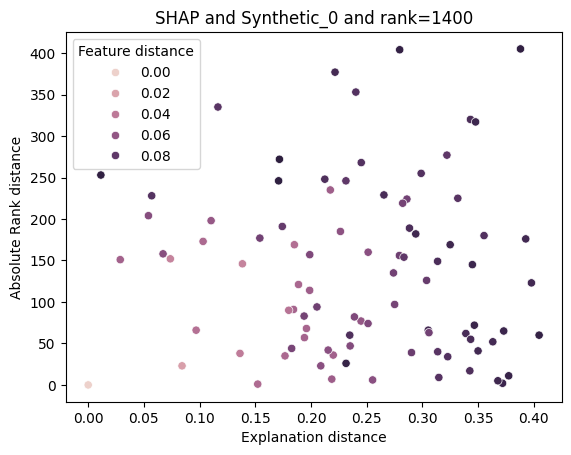

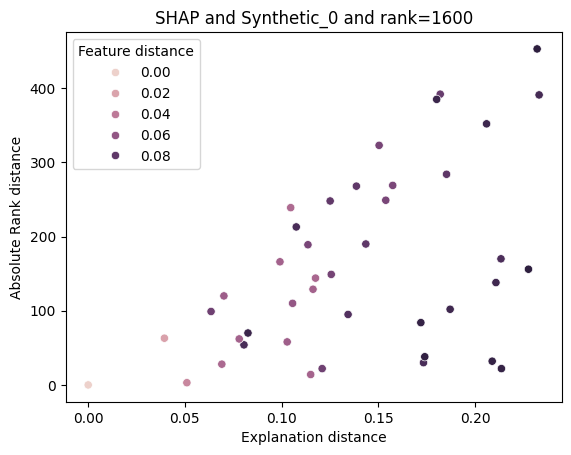

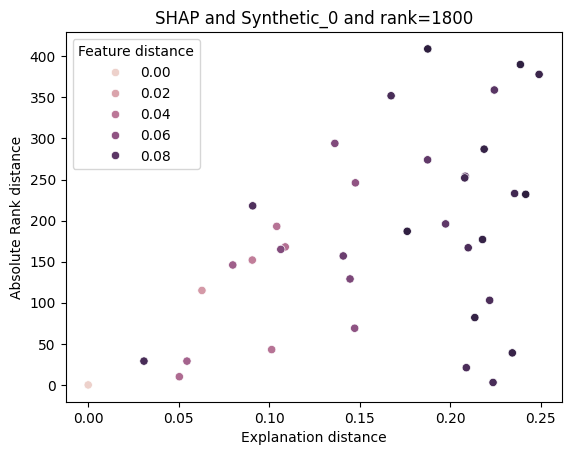

2000


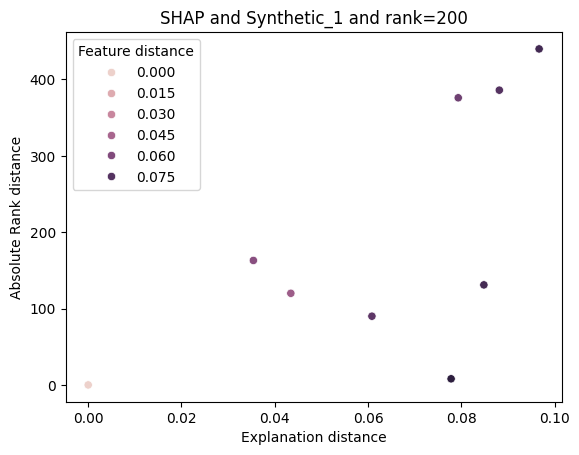

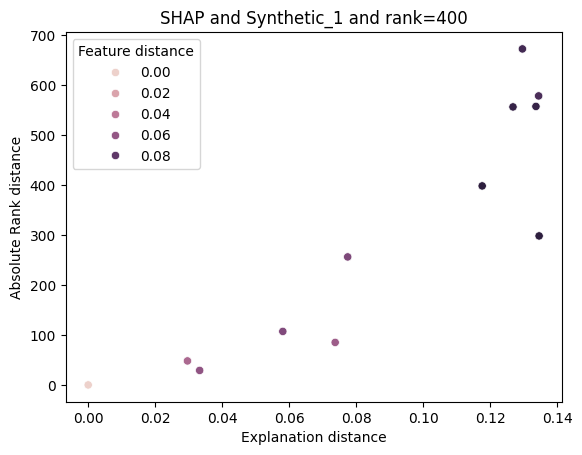

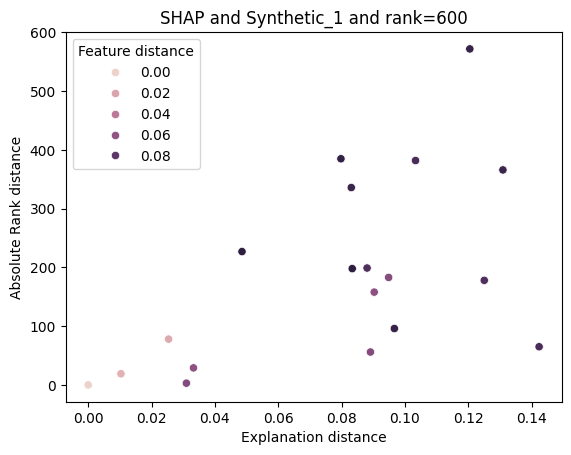

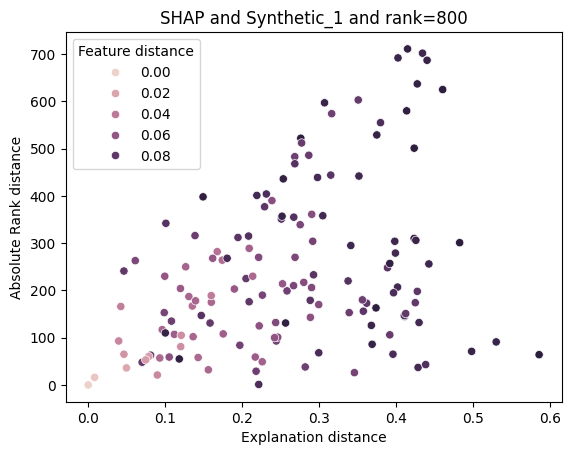

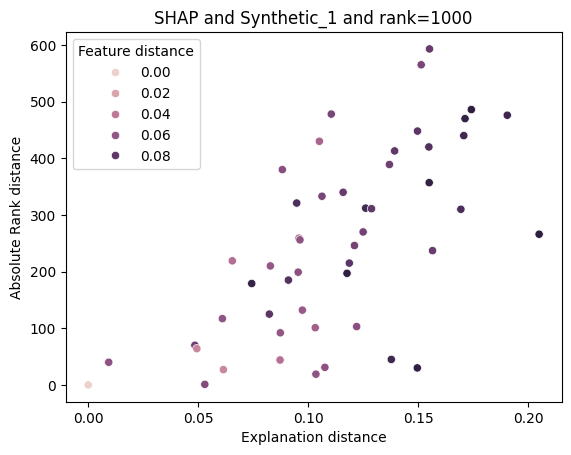

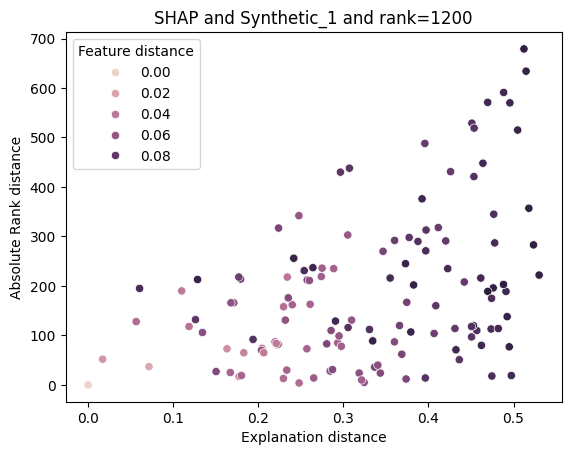

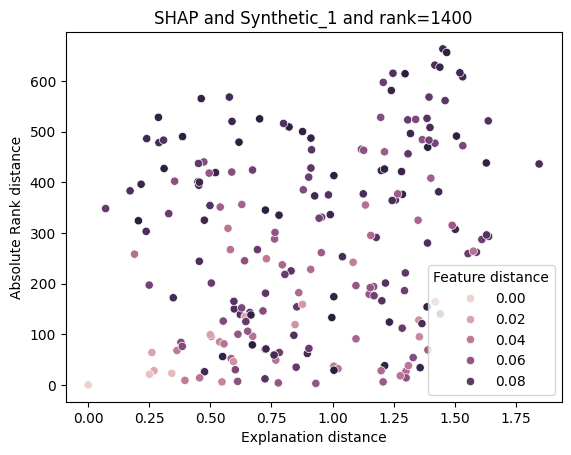

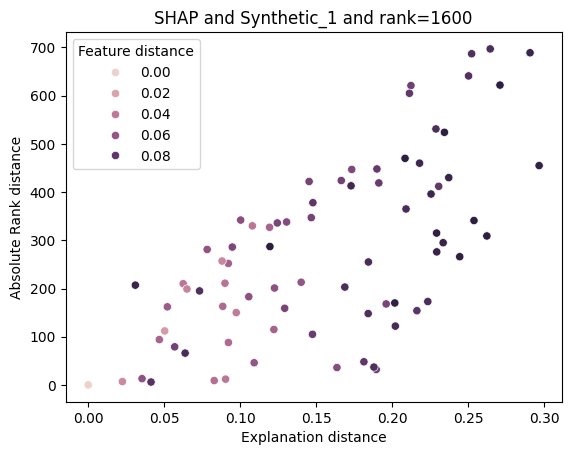

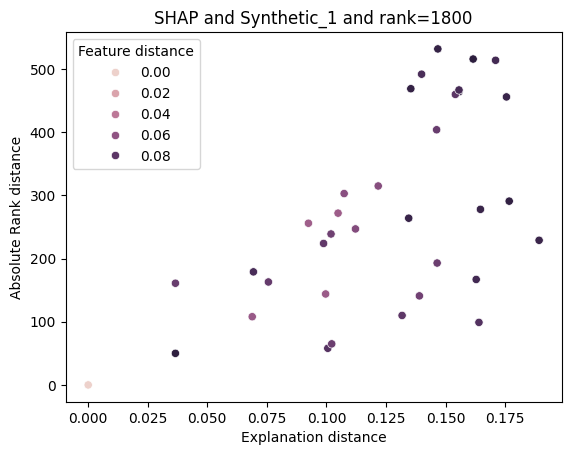

2000


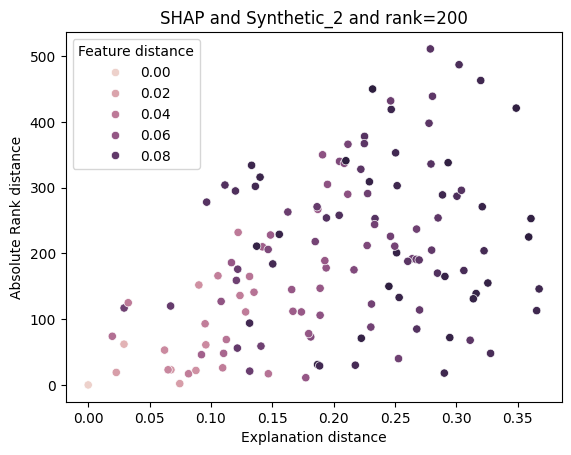

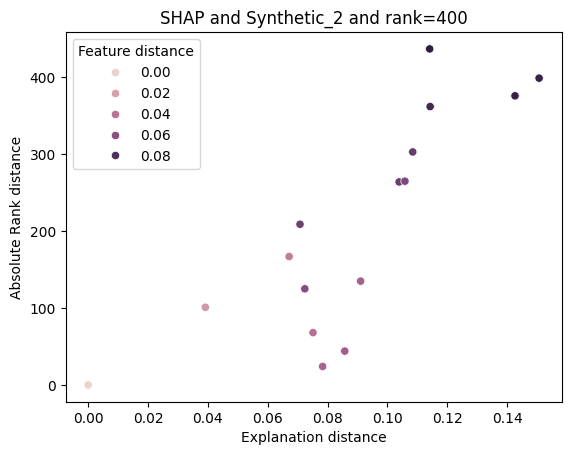

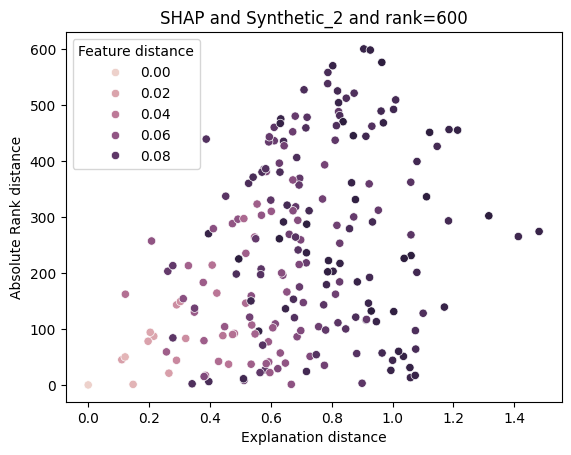

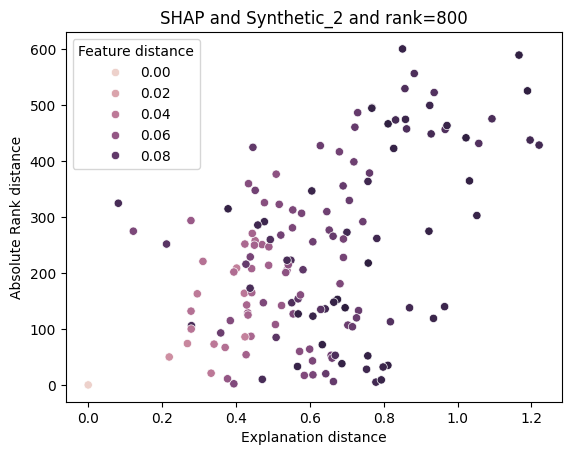

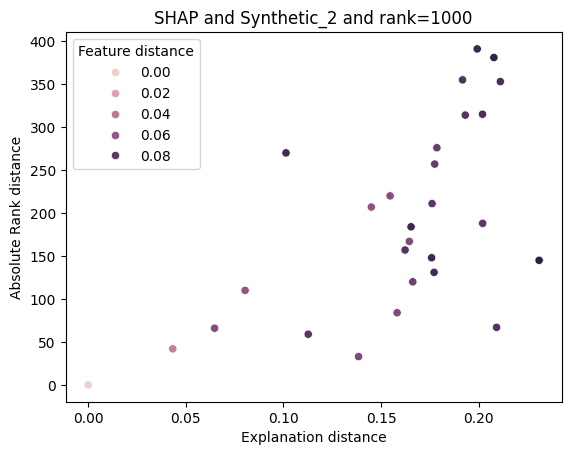

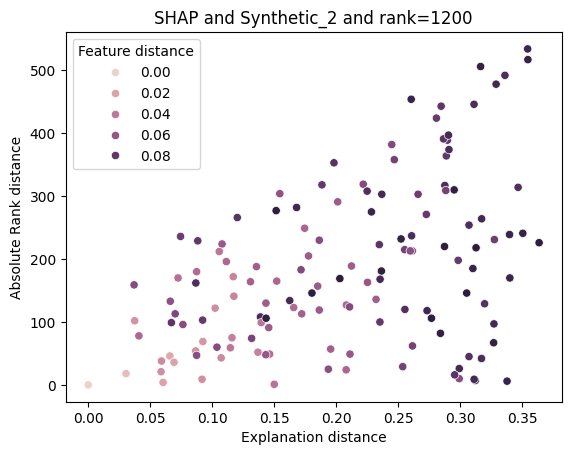

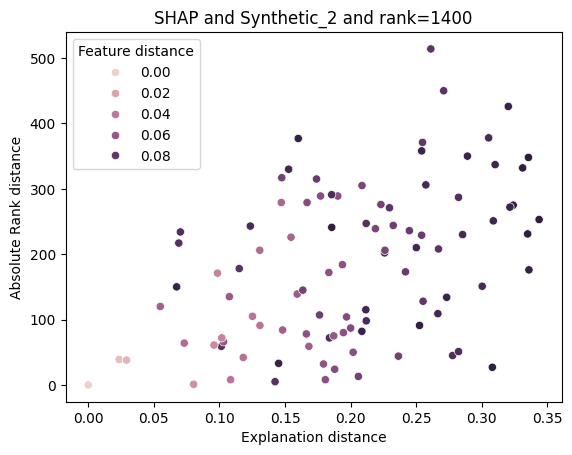

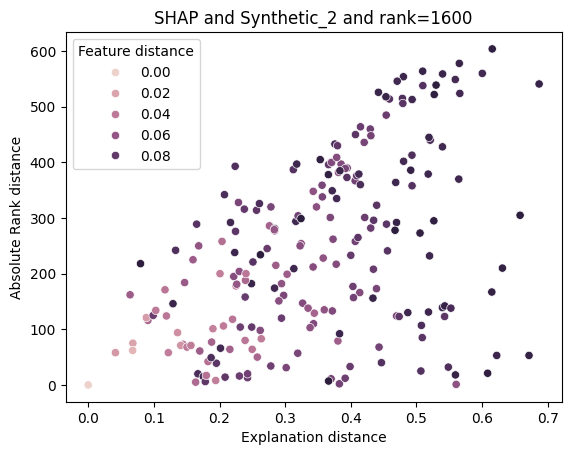

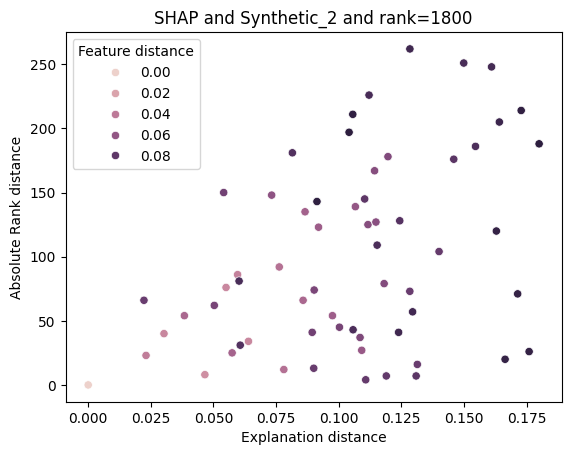

2000


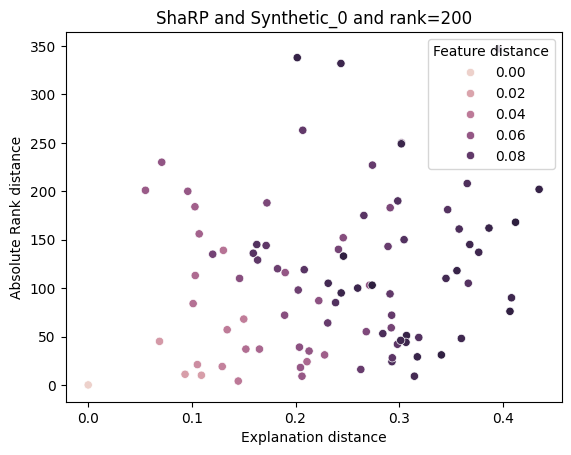

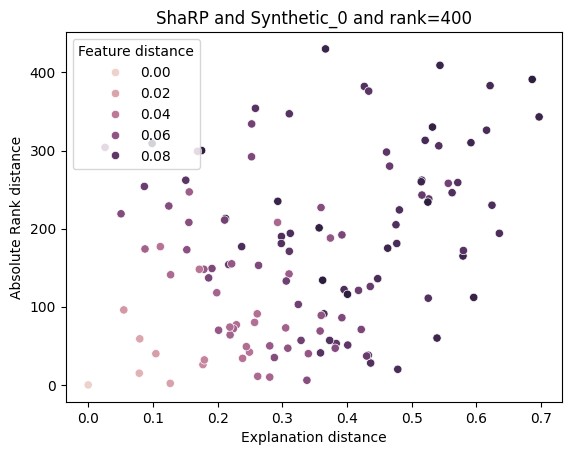

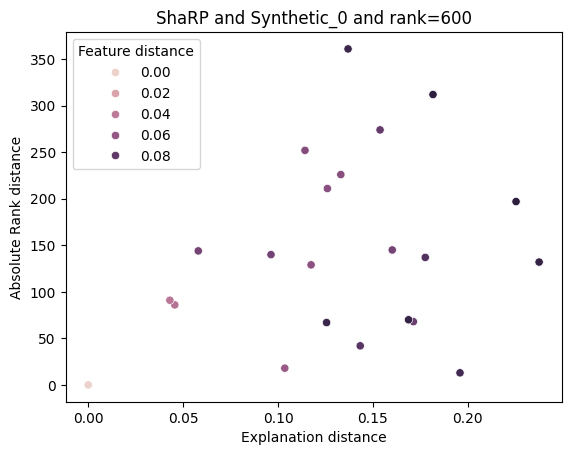

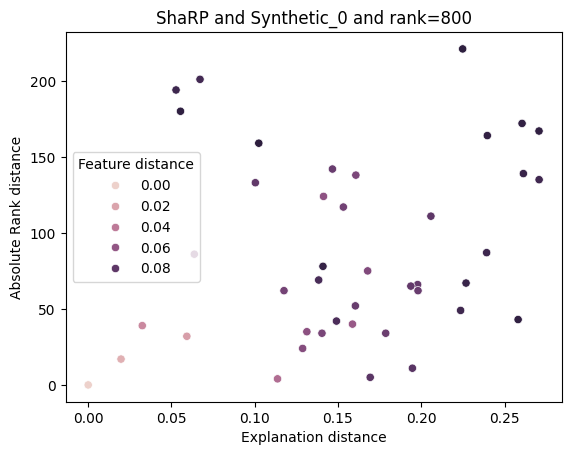

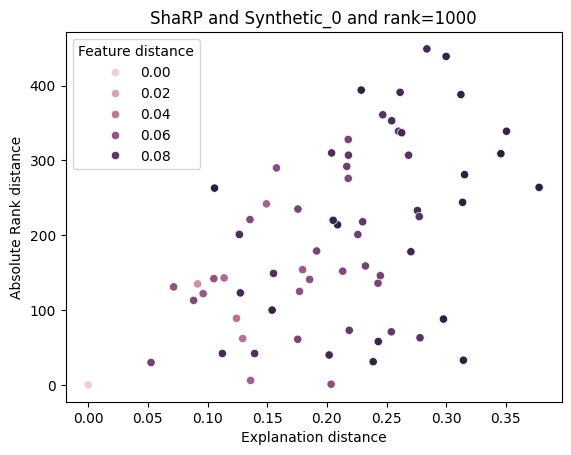

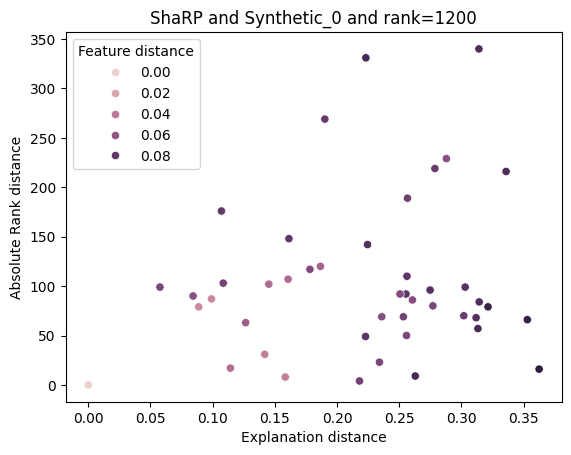

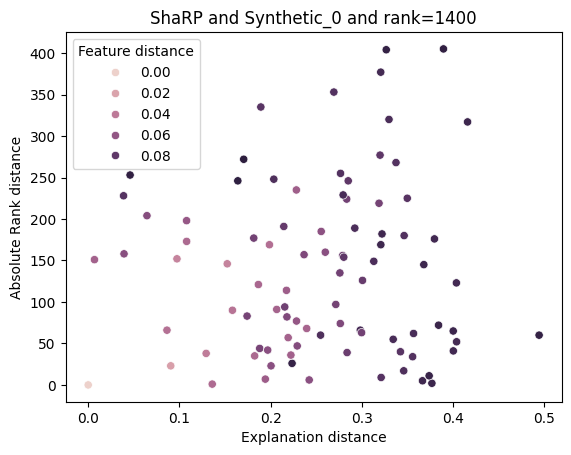

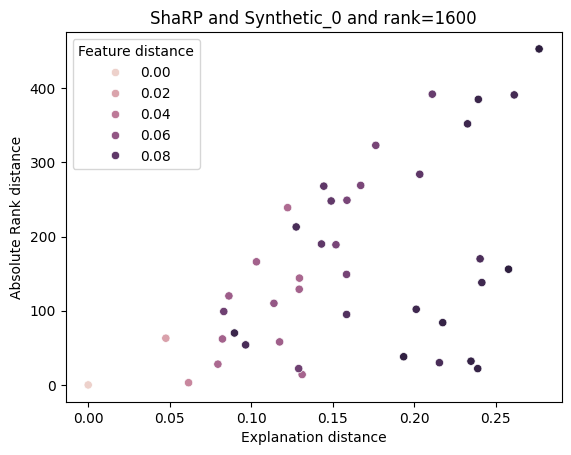

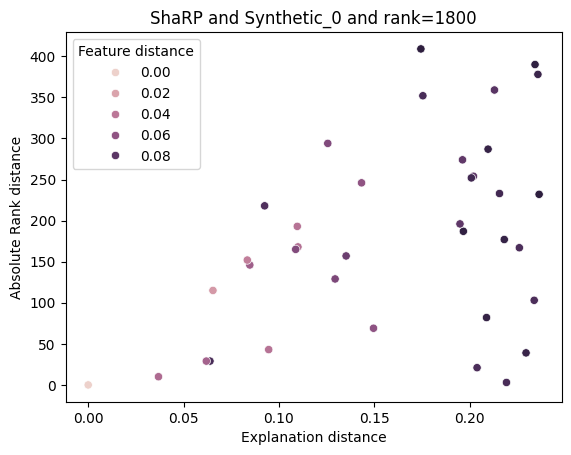

2000


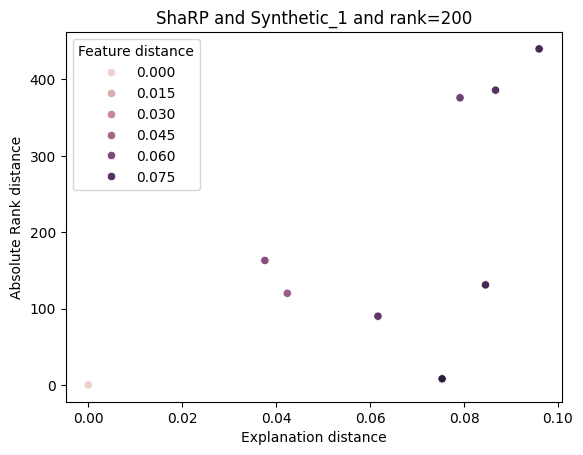

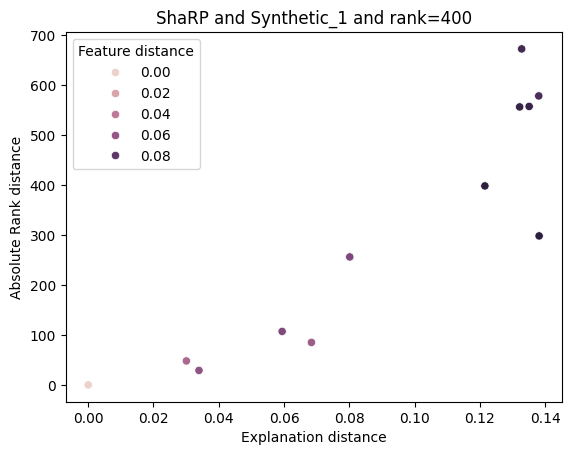

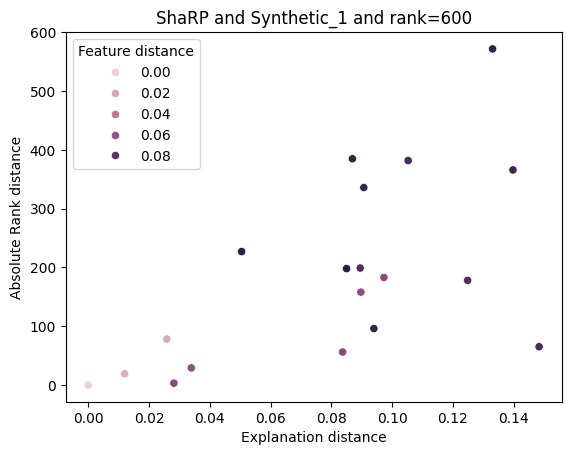

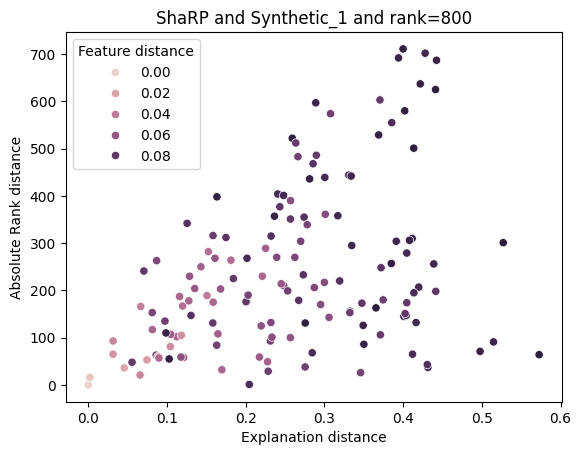

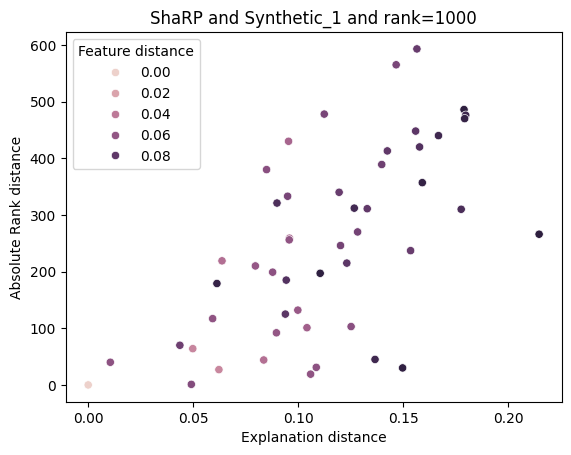

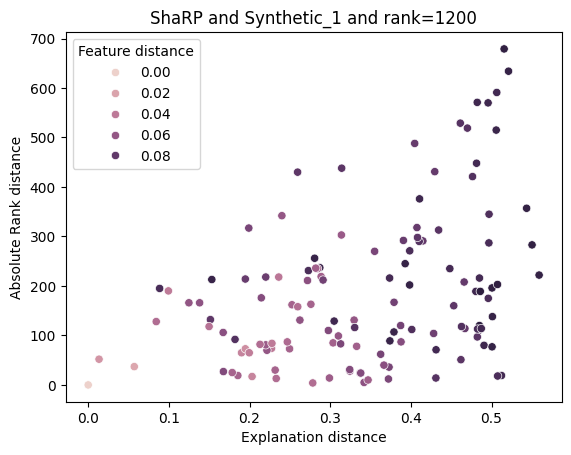

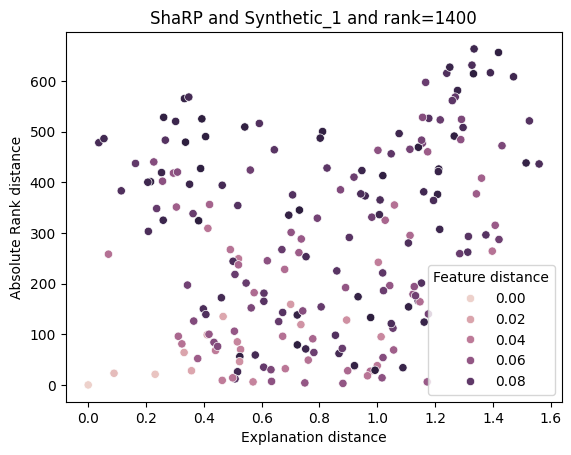

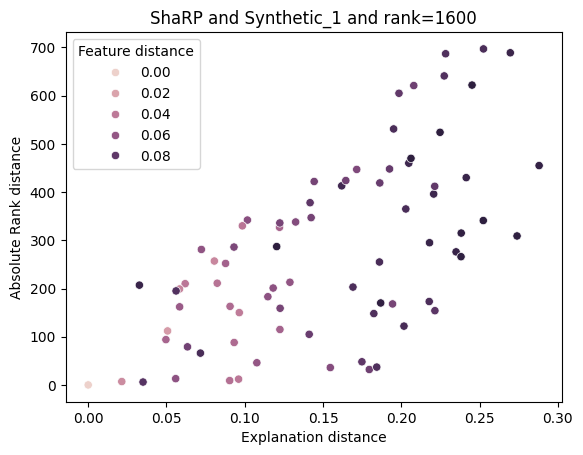

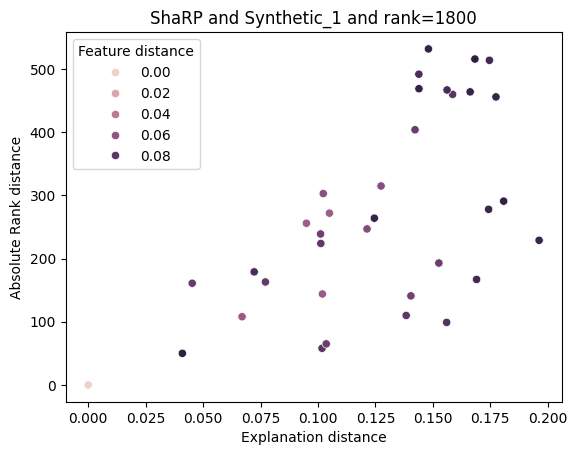

2000


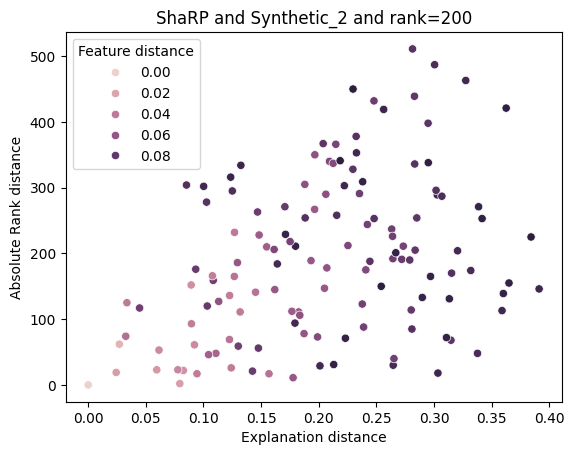

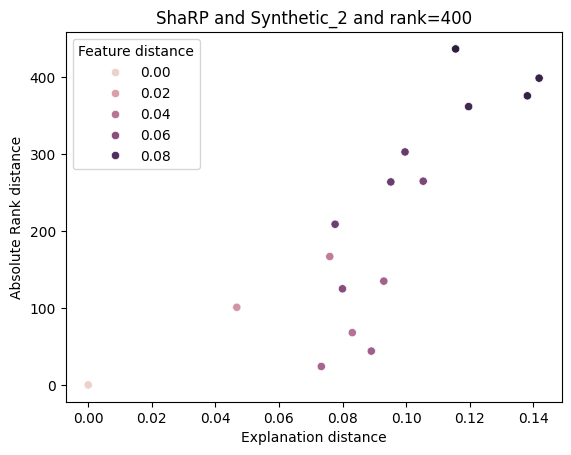

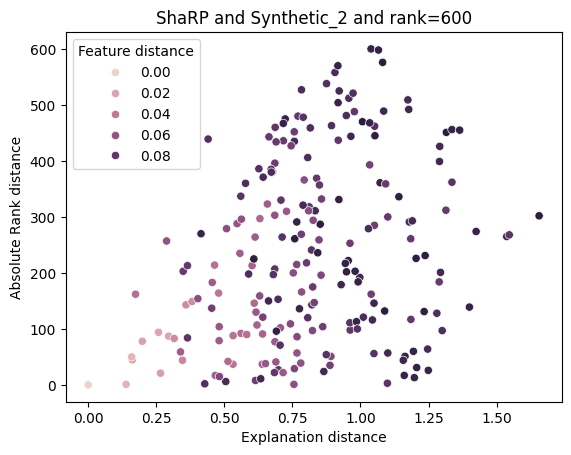

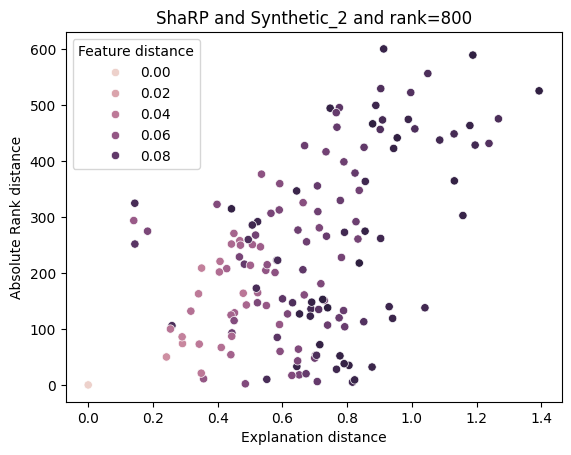

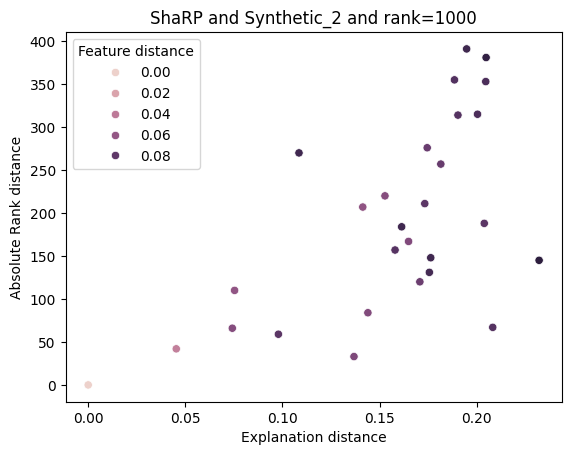

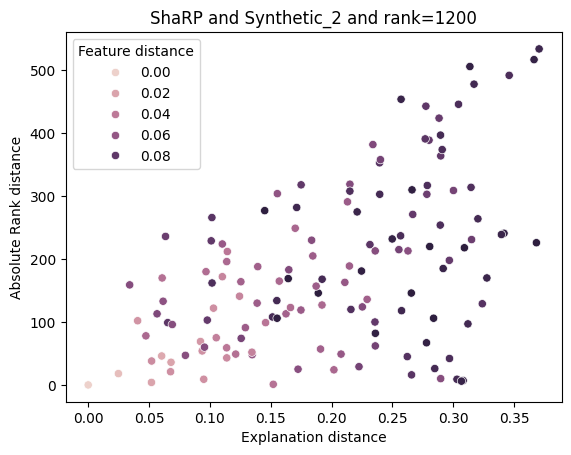

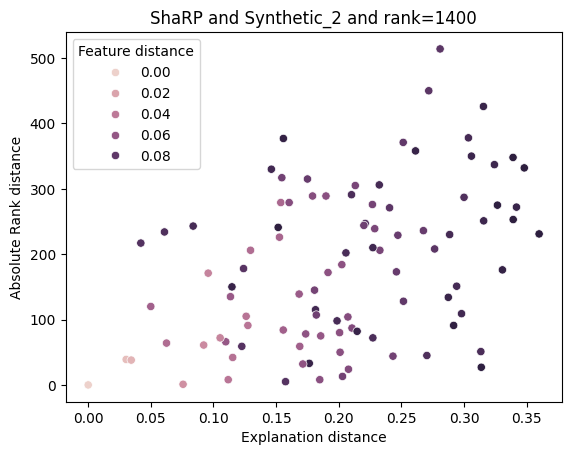

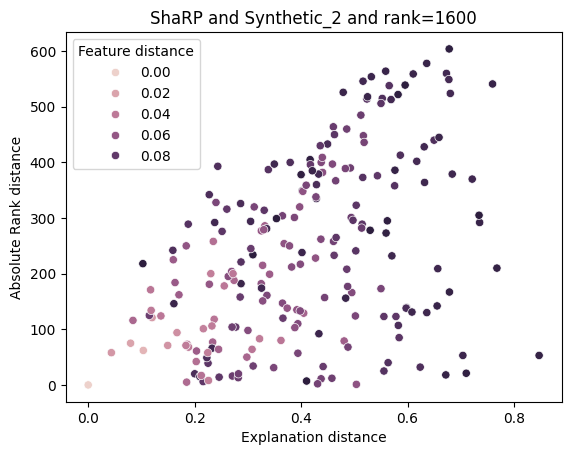

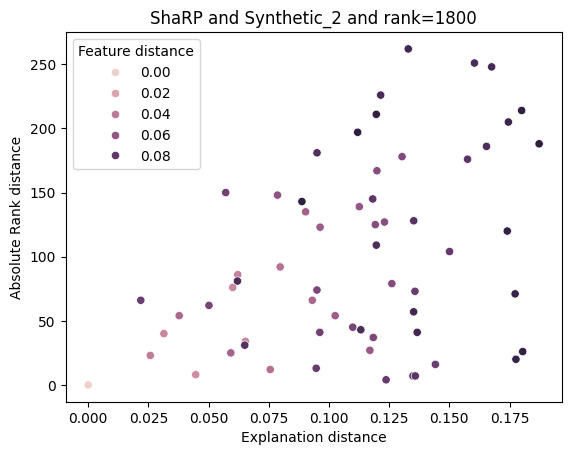

In [14]:
methods = [
    method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")
]

for method in methods:
    for dataset in datasets:
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        result = explanation_sensitivity_all_neighbors(
            dataset["data"][0],
            results[dataset["name"]][method][0],
            rankings,
            measure="euclidean",
            # n_features=0.8,
            threshold=0.1,
        )

        df_length = dataset["data"][0].shape[0]
        print(df_length)
        for plot_idx in [int(num / 10 * df_length) for num in range(1, 10, 1)]:
            measure_distances, rank_distances, feature_distances = result(
                row_idx=plot_idx
            )

            temp = pd.DataFrame()

            temp["Explanation distance"] = measure_distances
            temp["Absolute Rank distance"] = np.absolute(rank_distances)
            temp["Feature distance"] = feature_distances
            sns.scatterplot(
                data=temp,
                x="Explanation distance",
                y="Absolute Rank distance",
                hue="Feature distance",
            )
            plt.title(f'{method} and {dataset["name"]} and rank={plot_idx}')

            plt.savefig(
                f"results/sensitivity-scatterplot-{dataset["name"]}-{method}-{plot_idx}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True,
            )

            plt.show()

# Explanation Consistency

In [15]:
help(cross_method_explanation_consistency)

Help on function cross_method_explanation_consistency in module xai_ranking.metrics._consistency:

cross_method_explanation_consistency(results1, results2, measure='kendall', **kwargs)



In [16]:
methods = [
    method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")
]

exp_cons_res = {}
exp_cons_sem = {}
for dataset in datasets:
    exp_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        try:
            result = cross_method_explanation_consistency(
                results[dataset["name"]][method1][0],
                results[dataset["name"]][method2][0],
                measure="kendall",
            )

            exp_cons_res[dataset["name"]].loc[method1, method2] = result[0]
            exp_cons_sem[dataset["name"]].loc[method1, method2] = result[1]
        except:
            pass

In [17]:
exp_cons_res

{'Synthetic_0':            SHAP     ShaRP
 SHAP        0.0  0.029333
 ShaRP  0.029333       0.0,
 'Synthetic_1':         SHAP  ShaRP
 SHAP     0.0  0.007
 ShaRP  0.007    0.0,
 'Synthetic_2':            SHAP     ShaRP
 SHAP        0.0  0.023667
 ShaRP  0.023667       0.0}

In [18]:
avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res.items():
    # if dataset != "Moving Company":
    # avg_exp_cons_res += res_
    avg_exp_cons_res += res_

avg_exp_cons_res /= len(datasets)
avg_exp_cons_res

/state/partition1/job-48890958/ipykernel_1909572/1798256637.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)


,SHAP,ShaRP
SHAP,0.0,0.02
ShaRP,0.02,0.0


# Score to rank plots

Synthetic_0


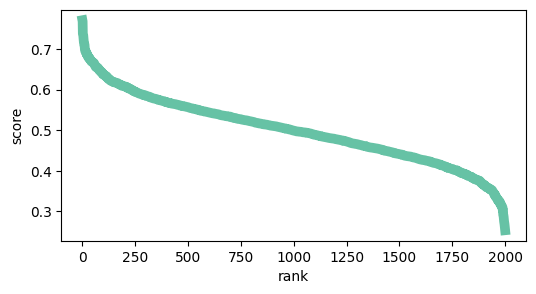

Synthetic_1


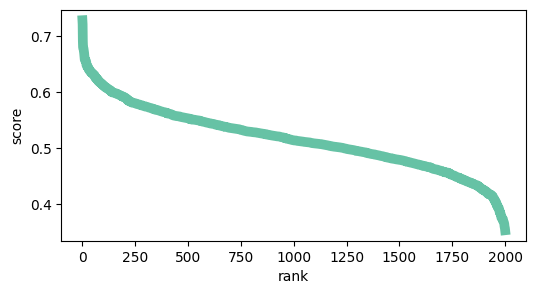

Synthetic_2


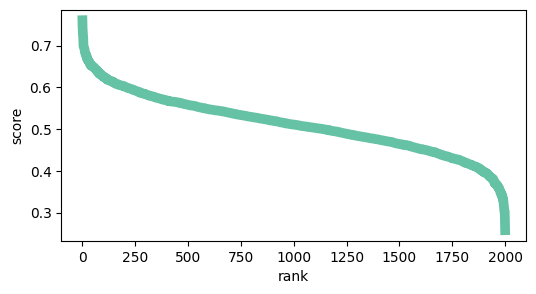

In [19]:
# Score to rank plots

import seaborn as sns

for dataset in datasets:
    print(dataset["name"])
    df = pd.DataFrame()
    df["rank"] = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
    if dataset["name"] == "ATP":
        df["score"] = dataset["scorer"](dataset["data"][0]).values
    else:
        df["score"] = dataset["scorer"](dataset["data"][0])
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), sharey="row")
    ax = sns.lineplot(data=df, x="rank", y="score", linewidth=7, c="#66c2a5")
    ax.set_ylabel("score")
    ax.set_xlabel("rank")

    fig.savefig(
        f"results/rank-vs-score-linechart-{dataset["name"]}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

# Independence Analysis

In [20]:
import sharp.visualization._aggregate as agg
from sharp.visualization import waterfall

SHAP


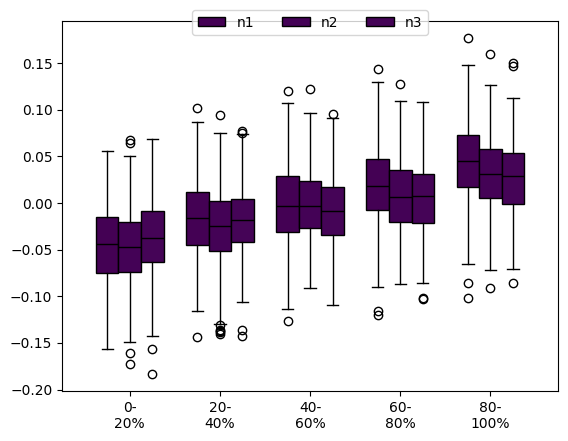

SHAP


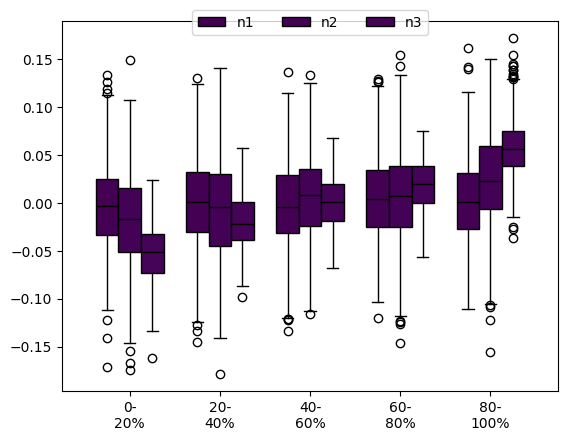

SHAP


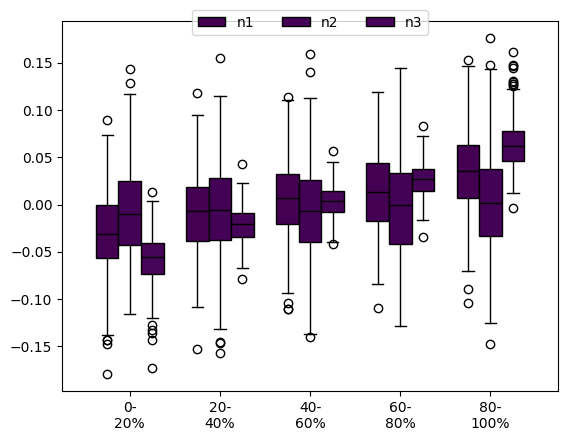

ShaRP


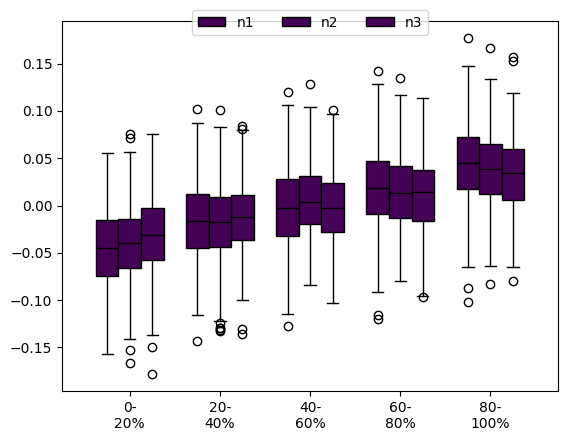

ShaRP


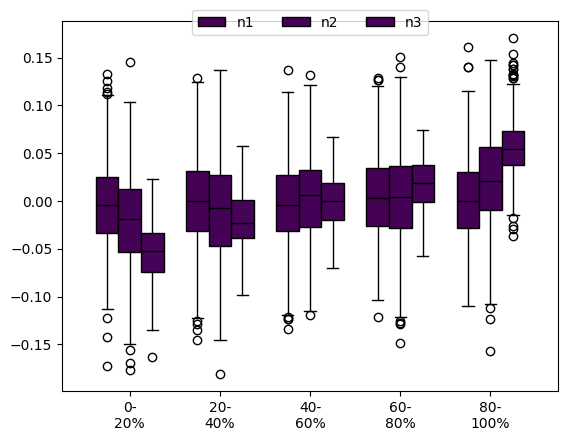

ShaRP


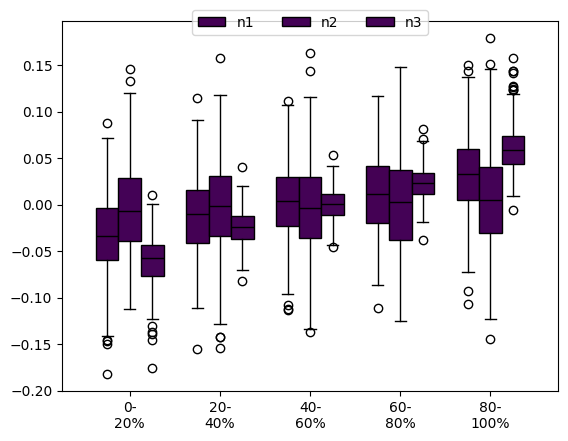

In [21]:
methods = [
    method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")
]

for method in methods:
    for dataset in datasets:
        print(method)
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        agg.strata_boxplots(
            dataset["data"][0], rankings, results[dataset["name"]][method][0]
        )